In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file = 'global_data_10_1'
time_bins = np.arange(0,24,float(file.split('_')[-1]))
H_bins = np.arange(90,130,float(file.split('_')[-2]))

shape = len(time_bins) * len(H_bins)

file_path = f'../../Output/{file}.csv'

In [9]:
data_df = pd.read_csv(file_path,low_memory=False)
Ne_EXP = np.array(data_df['EXP Density']).reshape(-1,shape)
dNe_EXP =  np.array(data_df['EXP Density Error']).reshape(-1,shape)
Ne_WACCM = np.array(data_df['WACCM Density']).reshape(-1,shape)
mag_EXP = np.array(data_df['EXP Magnitude']).reshape(-1,shape)
mag_WACCM = np.array(data_df['WACCM Magnitude']).reshape(-1,shape)
height = np.array(data_df['Height']).reshape(-1,shape)
Date = np.array(data_df['Date']).reshape(-1,shape)[:,0]
Svalbard = np.array(data_df ['Svalbard']).reshape(-1,shape)[:,0] == 1
Tromso = np.array(data_df['Tromso']).reshape(-1,shape)[:,0] == 1
Geomagnetic_Event = np.array(data_df['Geomagnetic Event']).reshape(-1,shape)[:,0] == 1
Solar_Proton_Event = np.array(data_df['Solar Proton Event']).reshape(-1,shape)[:,0] == 1
SMU_index = np.array(data_df['SMU']).reshape(-1,shape)
dSMU_index = np.array(data_df['SMU Gradient']).reshape(-1,shape)

mask, type = np.repeat(True, len(Ne_EXP)), 'all'
mask, type = Svalbard, 'Svalbard'
mask, type = Tromso, 'Tromso'
mask, type = Geomagnetic_Event, 'geo'
mask, type = Solar_Proton_Event, 'sol'
mask, type = (~Geomagnetic_Event) * (~Solar_Proton_Event), 'quiet'
mask, type = (Geomagnetic_Event) + (Solar_Proton_Event), 'active'

Ne_EXP = Ne_EXP[mask]
dNe_EXP = dNe_EXP[mask]
Ne_WACCM = Ne_WACCM[mask]

mag_EXP = mag_EXP[mask]
mag_WACCM = mag_WACCM[mask]

SMU_index = SMU_index[mask]
dSMU_index = dSMU_index[mask]
height = height[mask]

Geomagnetic_Event = Geomagnetic_Event[mask]
Solar_Proton_Event = Solar_Proton_Event[mask]

zero_mask = Ne_EXP != 0
Ne_EXP[~zero_mask] = 1
Ne_WACCM[~zero_mask] = 1
mag_EXP[~zero_mask] = 1
mag_WACCM[~zero_mask] = 1
height[~zero_mask] = 0

Ne_diff = np.abs(Ne_EXP - Ne_WACCM)
error_mask = Ne_diff < dNe_EXP
count_error = np.sum(Ne_EXP != 1, axis=0)

Ne_EXP[error_mask] = 1
dNe_EXP[error_mask] = 0
Ne_WACCM[error_mask] = 1
mag_EXP[error_mask] = 1
mag_WACCM[error_mask] = 1
height[error_mask] = 0

dNe_fac = dNe_EXP/Ne_EXP
factor_error_mask = dNe_fac > 2
dNe_EXP_2 = dNe_fac

Ne_EXP[factor_error_mask] = 1
dNe_EXP[factor_error_mask] = 0
dNe_fac[factor_error_mask] = 0
Ne_WACCM[factor_error_mask] = 1
mag_EXP[factor_error_mask] = 1
mag_WACCM[factor_error_mask] = 1
height[factor_error_mask] = 0

zero_mask = Ne_EXP != 0
Ne_EXP[~zero_mask] = 1
dNe_fac[~zero_mask] = 0
Ne_WACCM[~zero_mask] = 1
mag_EXP[~zero_mask] = 1
mag_WACCM[~zero_mask] = 1
height[~zero_mask] = 0

value_mask = Ne_EXP != 1

print(np.min(SMU_index), np.max(SMU_index))
print(np.min(dSMU_index), np.max(dSMU_index))

0.0 1590.8
-677.2 1046.19


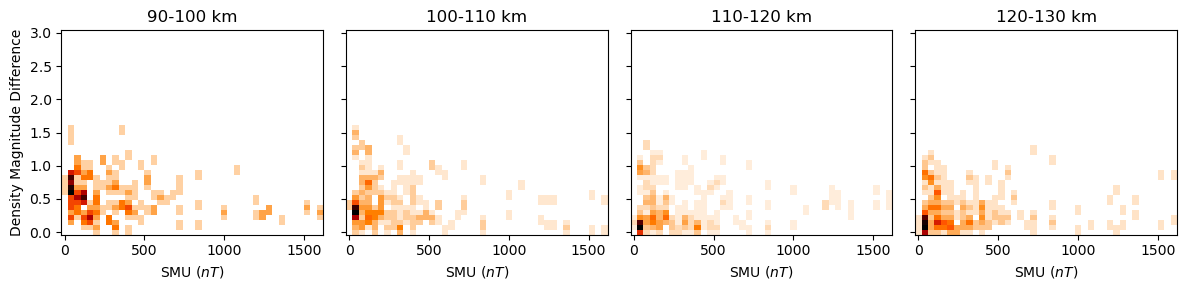

In [10]:
SMU = np.linspace(0,400,41)
dSMU = np.linspace(-200,200,41)
#SMU = np.linspace(0,1600,41)
#dSMU = np.linspace(-800,800,41)
mag_diff1 = np.linspace(0,3,41)
mag_diff2 = np.linspace(0,3,41)


height_flat = height[zero_mask]
SMU_flat = SMU_index[zero_mask]
dSMU_flat = dSMU_index[zero_mask]
Ne_diff_flat = np.abs(mag_EXP - mag_WACCM)[zero_mask]

fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)

index = 0
for H_bin in H_bins:
    grid = []
    test = []
    index2 = 0
    h_mask = height_flat == H_bin
    for value1 in SMU:
        mask1 = np.abs(SMU_flat[h_mask] - value1) <= (SMU[1] - SMU[0])/2
        for value2 in mag_diff1:
            mask2 = np.abs(Ne_diff_flat[h_mask][mask1] - value2) <= mag_diff1[1]
            grid.append(sum(mask2))
            test.append(index2)
            index2 += 1

    grid = np.array(grid).reshape(len(SMU), len(mag_diff1)).T
    X, Y = np.meshgrid(SMU, mag_diff1)
    axs[index].pcolormesh(X, Y, grid, cmap = 'gist_heat_r')
    axs[index].set_title(f'{int(H_bin)}-{int(H_bin+10)} km')
    axs[index].set_xlabel(r'SMU ($nT$)')
    index += 1


axs[0].set_ylabel('Density Magnitude Difference')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/{type}/SMU.png')
plt.show()

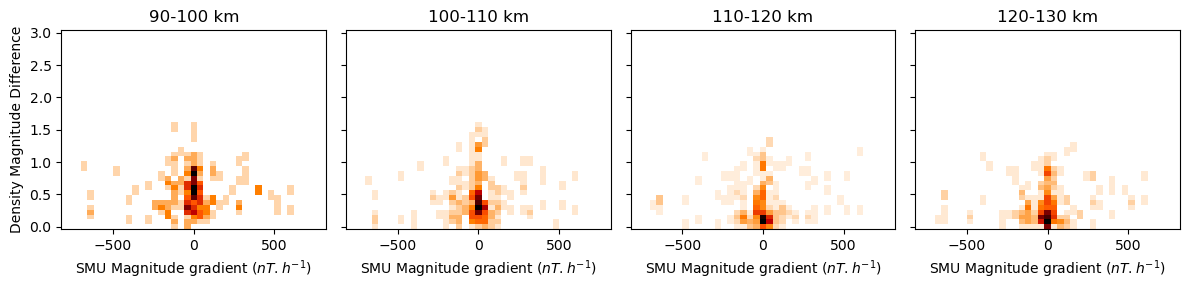

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)

index = 0
for H_bin in H_bins:
    grid = []
    test = []
    index2 = 0
    h_mask = height_flat == H_bin
    for value1 in dSMU:
        mask1 = np.abs(dSMU_flat[h_mask] - value1) <= (dSMU[1] - dSMU[0])/2
        for value2 in mag_diff2:
            mask2 = np.abs(Ne_diff_flat[h_mask][mask1] - value2) <= mag_diff2[1]
            grid.append(sum(mask2))
            test.append(index2)
            index2 += 1

    grid = np.array(grid).reshape(len(dSMU), len(mag_diff2)).T
    X, Y = np.meshgrid(dSMU, mag_diff2)
    axs[index].pcolormesh(X, Y, grid, cmap = 'gist_heat_r')
    axs[index].set_title(f'{int(H_bin)}-{int(H_bin+10)} km')
    axs[index].set_xlabel(r'SMU Magnitude gradient ($nT.h^{-1}$)')
    index += 1

axs[0].set_ylabel('Density Magnitude Difference')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/{type}/SMU-gradient.png')
plt.show()